# PyKinSim ‒ A Tutorial

> **🖈 Note:** Throughout this tutorial, you will encounter these “note blocks”. These include additional information that may not be super relevant the first time you read through this, so feel free to skip them.

> **🖈 Note:** In case you want to follow along, make sure you've sucessfully installed *PyKinSim*. See `README.md` in the top-level directory of this repository for more information on the installation procedure.

In this tutorial we're going over the key features of *PyKinSim*. This tutorial is divided into a few “lectures” concerned with the following core concepts:
* **Lecture 1:**  
  Building and simulating a model, point masses, gravity, symbolic evaluation
* **Lecture 2:**  
  Fixtures, joints, and links
* **Lecture 3:**  
  Applying torques for control
  
## Lecture 1: A Falling Point Mass

One of the most simple mechanical systems is a point mass in free fall. Hence, in this first part of the tutorial, we use this system to explore some of the core concepts of *PyKinSim* using.

Before we start, however, we need to import `pykinsim` and
a few other libraries into Python.

In [1]:
import pykinsim as pks
import numpy as np
import matplotlib.pyplot as plt

### Building a *PyKinSim* Model
Modeling such a system in *PyKinSim* is a matter of two lines of code.

In [2]:
with pks.Chain() as chain:
    m1 = pks.Mass(m=1.0)

The first line `with pks.Chain() as chain:` starts a "model description block". All `pks` objects (e.g., our `Mass`) created within this block are automatically added to the `chain` instance. Hence, you can think of the `Chain` class as being used as a container for the model you are building.

> **🖈 Note:** While encouraged, you do not have to use the “`with`” construct. You an also pass the `chain` instance to which an object should be attached as the `parent` in the object's constructor.

> **🖈 Note:** The name `Chain` was chosen because the class of rigid body systems simulated by *PyKinSim* are known as “Kinematic Chains”.

### Simulating a *PyKinSim* Model

In order to simulate the model we've just built, we need to create a `Simulator` and pass our `chain` object to it. The next code snippet shows you how to do this. Also, it will simulate the model for a second and record the location of the mass.

In [3]:
ts, pos = [], []
with pks.Simulator(chain) as sim:
    sim.run(T=1.0, callback=lambda state:
            (ts.append(state.t),
             pos.append(sim.kinematics(state)[m1][:3, 3])))

Hopefully, this code isn't too surprising. We are passing the `chain` object we created above to a new `Simulator` instance; then, we tell the simulator to run the simulation for one second. Every timestep, the given callback is called, and the location of the object, as well as the current time is stored in the lists “`ts`”, and “`pos`”, respectively.

> **🖈 Note:** You can control the (maximum) simulation timestep by passing a parameter `dt` to `run`. Also, you can (independently) control the interval in which the callback is called by passing the argument `callback_interval` (which defaults to `dt`).

> **🖈 Note:** The `chain` object will be mutated by the constructor of the `Simulator` object. Once the simulator object has been created, changes to the original `chain` object are likely to not affect the simulation. A good practice is to construct a single `Chain` instance for each `Simulator` instance, and to not change the `Chain` once the `Simulator` has been created.

#### Transformations

What might be a little confusing is the snippet “`sim.kinematics(state)[m1][:3, 3]`”.

The function `sim.kinematics(state)` computes the so-called forward-kinematics for a given simulation state and every object. The forward kinematics describe the location and orientation of each object in our system given the system configuration (state).

> **🖈 Note:** In the case of our free-falling mass the `state` of the system is rather boring, since the system is solely described by the orientation and location of the single point-mass. However, once we add `Joint` objects to our model, things will get more interesting (see the next lecture below).

The result of `sim.kinematics(state)` is a map from object references onto transformation matrices. *PyKinSim* represents the location and orientation of an object in terms of an affine 4x4 transformation matrix:
$$\begin{pmatrix}
    r_{11} & r_{12} & r_{13} & t_\mathrm{x} \\
    r_{21} & r_{22} & r_{23} & t_\mathrm{y} \\
    r_{31} & r_{32} & r_{33} & t_\mathrm{z} \\
    0      & 0      & 0      & 1
\end{pmatrix}$$

Here, the coefficients $r_{ij}$ are a rotation matrix describing the orientation of the object with respect to the global reference frame, whereas the coefficients $t_\mathrm{x}, t_\mathrm{y}, t_\mathrm{z}$ are the location (or translation with respect to the origin). In case you are only interested in the location of an object, you can ignore the rotation part of the matrix and extract the location part using the `numpy` slice syntax `[:3., 3]`, as we've done above.

#### Plotting the results

Having discussed transformations, let's plot the recorded data using `matplotlib`:

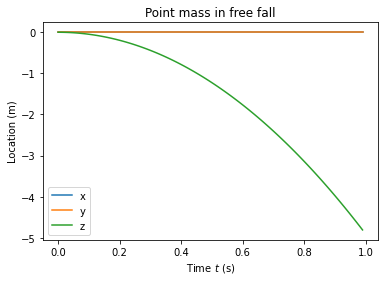

In [4]:
def plot_locations(ts, pos, title=""):
    fig, ax = plt.subplots()
    for i, axis in enumerate("xyz"):
        ax.plot(ts, np.array(pos)[:, i], label=axis)
    ax.set_xlabel("Time $t$ (s)")
    ax.set_ylabel("Location (m)")
    ax.set_title(title)
    ax.legend()
plot_locations(ts, pos, "Point mass in free fall")

As the plot shows, the object is moving along the $z$-axis with a constant acceleration; i.e., it is falling and reaches a location of $t_\mathrm{z} = -4.905\,\mathrm{m}$ at $t = 1\,\mathrm{s}$.

### Gravity

Where do these numbers come from? How does the object “know” to “fall” down along the $z$-axis? The answer is that the simulator instance receives the gravity vector $\vec g$ as part of its initialisation, with a default of $(0, 0, 9.81)$.

> **🖈 Note:** The gravity vector is pointing “up”, since it is used to describe the potential energy of an object within the gravity field, i.e., $\mathit{PE} = m\langle \vec g, \vec x \rangle$. The object “wants” to minimize it's potential energy, so it falls down.

We can repreat the above experiment with a different gravity vector, or no gravity at all. In the latter case, we will observe that the object is not moving, as you may expect:

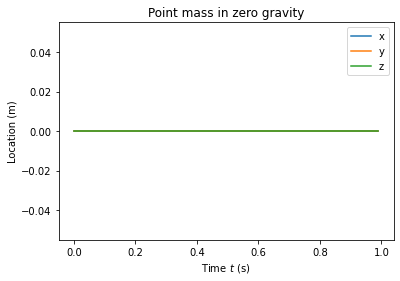

In [5]:
ts, pos = [], []
with pks.Simulator(chain, g=(0.0, 0.0, 0.0)) as sim:
    sim.run(T=1.0, callback=lambda state:
            (ts.append(state.t),
             pos.append(sim.kinematics(state)[m1][:3, 3])))
plot_locations(ts, pos, "Point mass in zero gravity")

More generally speaking, as long as there is no external force acting on our system (such as gravity or external torques), the system will not be moving.

In [6]:
# TODO